## Contents:

* <a href='#intro'>Objectives and Introduction</a>
* <a href='#preprocessing'>preprocessing</a>
    * <a href='#loadData'>Load Data</a>
    * <a href='#addColumns'> Add a few columns to the data</a>
    * <a href='#normalizeFuel'>Speed is impacted by fuel weight. Calculate fuel consumption line</a>
    * <a href='#CalculateSlopes'>Extract slope of lines for different stints</a>
    * <a href='#bestQual'>Get best lap-times from qualifying</a>
* <a href='#preprocessing'>preprocessing</a>


In [310]:
path = '/home/datascience/WorkSpace/RedBull-Racining-TimeToPit/notebooks/'  

<a id='intro'></a>

<p style="font-size:20px;">
<font color="black">
Introduction: Experiment with Machine Learning and Win a Race Simulation with Red Bull Racing
<font color="gray">
<p style="margin-left:3%; margin-right:10%;font-size:16px;">
 
Explore data, deploy a predictive machine learning model … and win a simulated Red Bull Race against your peers.
 
You’re the race strategist at Red Bull Racing. Your mission? The night before the race, you’ll have to use machine learning to predict which factors contribute to determining the fastest race.
 
But there are multiple factors that go into predicting the fastest race, including different tire compounds, qualifying performance, historical data on which laps are chosen for pit stops, and expected weather conditions.
 
What are the variables that make all the difference?
 
In this two-hour workshop, you’ll have the opportunity to experiment with predictive models and choose which variables you think will determine a winning race. You’ll also learn about the steps of creating a machine learning model and become familiar with the entire process, and discover how to tie data science results back to the business.
 
Then … you get to try your own simulated race. We’ll run a simulation to see who has the best time, and who will win the best race of all time—the one you helped design.

<p style="font-size:20px;">
<font color="black">
Proposed solution:
<font color="gray">
<p style="font-size:16px;">
Feature space is build by using directly measured features such as lap-time, best qual lap-time before the race etc, and some indirectly measured features such as, ... 

#### Load basic packages

In [311]:
import os
os.chdir(path)
import pandas as pd
import logging
import json
import pickle
import requests
import numpy as np
import fastf1
import seaborn as sns
import matplotlib.pyplot as plt
import util as util

<a id='loadData'></a>
## Load Data

In [312]:
'''
read data from export.json
save parsed data to rbr_data.csv
'''
df = util.historical_json_file_to_DF('../data/export.json', 'rbr_data.csv')

#### Select important columns

In [313]:
selected_cols = ['events', 'sessions', 'year1', 'country', 'year2', 'drivers_name',
       'tyres_type', 'tyres_compond', 'tyres_condition', 'setNumber',
       'lapNumber', 'lapType', 'runLapNumber', 'lapTime']
df = df[selected_cols]
df.head(10)

,events,sessions,year1,country,year2,drivers_name,tyres_type,tyres_compond,tyres_condition,setNumber,lapNumber,lapType,runLapNumber,lapTime
0,05Turkey11,P1,05,Turkey,11,Sebastian Vettel,INTERMEDIATE,INTERMEDIATE,NEW,0121,1,OUT_IN,1,NaN
1,05Turkey11,P1,05,Turkey,11,Sebastian Vettel,INTERMEDIATE,INTERMEDIATE,USED,0121,2,OUT,1,3088.068
2,05Turkey11,P1,05,Turkey,11,Sebastian Vettel,INTERMEDIATE,INTERMEDIATE,USED,0121,3,FULL,2,104.954
3,05Turkey11,P1,05,Turkey,11,Sebastian Vettel,INTERMEDIATE,INTERMEDIATE,USED,0121,4,IN,3,NaN
4,05Turkey11,P1,05,Turkey,11,Mark Webber,WET,WET,NEW,0231,1,OUT_IN,1,NaN
5,05Turkey11,P1,05,Turkey,11,Mark Webber,INTERMEDIATE,INTERMEDIATE,NEW,0221,2,OUT,1,2576.860
6,05Turkey11,P1,05,Turkey,11,Mark Webber,INTERMEDIATE,INTERMEDIATE,NEW,0221,3,FULL,2,103.365
7,05Turkey11,P1,05,Turkey,11,Mark Webber,INTERMEDIATE,INTERMEDIATE,NEW,0221,4,FULL,3,102.564
8,05Turkey11,P1,05,Turkey,11,Mark Webber,INTERMEDIATE,INTERMEDIATE,NEW,0221,5,IN,4,118.768
9,05Turkey11,P2,05,Turkey,11,Mark Webber,PRIME,HARD,NEW,0202,1,OUT,1,NaN


<a id='preprocessing'></a>
## Preprocessing
#### The following items is covered in this section
* The follwing items are covered in this section
    * <a href='#addColumns'> Add a few columns to the data to help creating subset of data</a>
    * <a href='#normalizeFuel'>Speed is impacted by fuel weight. Calculate fuel consumption line</a>
    * <a href='#CalculateSlopes'>Extract slope of tyre degradation lines for different stints</a>
    * <a href='#bestQual'>Get best lap-times from qualifying</a>

Lap-time is imacted by two major factors. 
a) Fuel consumption: weight of veicle is reduced when fuel is consumed and thus it runs faster
b) Tyre degradation: speed is reduced over the time due to tyre ware out

It is assumed that the fuel consumption is linear. Vehicle is pumped with 100Kg of fuel at the very begining of the race and it is zero as the very last race. To calculate fuel line, the lap-times are sampled at the begning of the stint and a line is fitted to the sampled data points. The goal is to estimate the green line and componsate the 

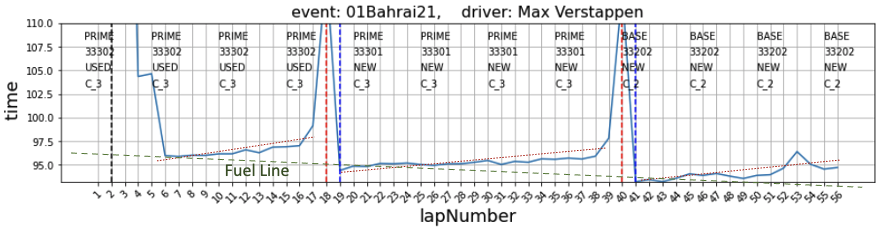

In [314]:
# df[(df['events']==evnt) &(df['sessions']=='Qual')]
# def func_best_qual_race():
#     print('a')
df1 = df.groupby(['events', 'country','sessions','drivers_name', 'tyres_compond','setNumber'])['lapTime'].min().reset_index(name='best_qual_time')
df2 = df1[df1['sessions']=='Qual'].sort_values(by=['events','country','drivers_name','setNumber','tyres_compond',]).reset_index(drop=True)
df3 = df1[df1['sessions']=='Race'].sort_values(by=['events','country','drivers_name','setNumber','tyres_compond']).reset_index(drop=True)
# df2 = df.join(df1, on= ['events', 'tyres_compond','setNumber'])

In [315]:
df2.head(20)

,events,country,sessions,drivers_name,tyres_compond,setNumber,best_qual_time
0,01Austra17,Austra,Qual,Daniel Ricciardo,ULTRA_SOFT,03503,85.383
1,01Austra17,Austra,Qual,Daniel Ricciardo,ULTRA_SOFT,03504,83.989
2,01Austra17,Austra,Qual,Daniel Ricciardo,ULTRA_SOFT,03505,121.448
3,01Austra17,Austra,Qual,Max Verstappen,ULTRA_SOFT,33503,85.868
4,01Austra17,Austra,Qual,Max Verstappen,ULTRA_SOFT,33504,84.482
5,01Austra17,Austra,Qual,Max Verstappen,ULTRA_SOFT,33505,84.789
6,01Austra17,Austra,Qual,Max Verstappen,ULTRA_SOFT,33506,84.092
7,01Austra17,Austra,Qual,Max Verstappen,ULTRA_SOFT,33507,83.485
8,01Austra18,Austra,Qual,Daniel Ricciardo,SUPER_SOFT,03402,82.897
9,01Austra18,Austra,Qual,Daniel Ricciardo,SUPER_SOFT,03403,120.453


In [316]:
df3.head(12)

,events,country,sessions,drivers_name,tyres_compond,setNumber,best_qual_time
0,01Austra17,Austra,Race,Max Verstappen,SUPER_SOFT,33402,86.964
1,01Austra17,Austra,Race,Max Verstappen,ULTRA_SOFT,33505,88.833
2,01Austra18,Austra,Race,Daniel Ricciardo,SOFT,03302,85.945
3,01Austra18,Austra,Race,Daniel Ricciardo,SUPER_SOFT,03402,88.127
4,01Austra18,Austra,Race,Max Verstappen,SOFT,33302,86.880
5,01Austra18,Austra,Race,Max Verstappen,SUPER_SOFT,33403,89.650
6,01Austra19,Austra,Race,Max Verstappen,C_3,33303,86.256
7,01Austra19,Austra,Race,Max Verstappen,C_4,33407,88.550
8,01Austra19,Austra,Race,Pierre Gasly,C_3,10303,88.412
9,01Austra19,Austra,Race,Pierre Gasly,C_4,10407,87.229


In [290]:
np.unique(df['events'][df['country']=='AbuDha'])

array(['17AbuDha20', '20AbuDha17', '21AbuDha18', '21AbuDha19'],
      dtype=object)

<a id='addColumns'></a>
#### Add a few columns to the data
Adding a few calculated columns which help to process data later in the notebook 

In [317]:
"""
Create a column to identify laps with a large delat-time between to consequtive laps
"""

df['large_delta_time'] = np.nan
df['delta_lapTime'] = np.nan


## create a column for delta_lapTime'
df['delta_lapTime'] = df.groupby(['events','drivers_name','sessions'])['lapTime'].diff()


## label thoes are biger or smaller than +-2
df['large_delta_time']= (df['delta_lapTime']<2) & (df['delta_lapTime']>-2)

In [319]:
## find best qual 
# df.groupby(['events','sessions', 'drivers_name', 'setNumber']).

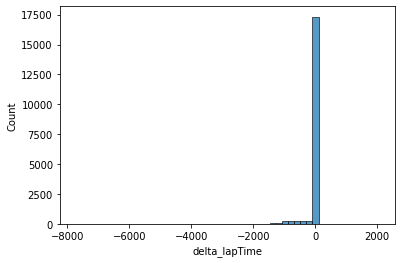

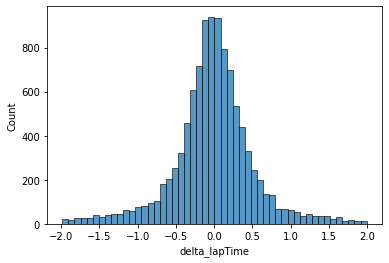

In [320]:
## detal-lapTime histogram without filtering
sns.histplot(df[df['delta_lapTime'].notnull()],x = 'delta_lapTime', bins=50)
plt.show()

## detal-lapTime histogram with filtering
sns.histplot(df[df['large_delta_time']],x = 'delta_lapTime', bins=50)
plt.show()

In [321]:
## calculate Stint length
df_stintLen = df.groupby(['events','sessions', 'drivers_name', 'setNumber']).size().reset_index(name='stintLength')
df = df.merge(df_stintLen, on = ['events','sessions', 'drivers_name', 'setNumber'])

## if the stint greater than 5 laps
df['greater_than_5_laps'] = df['stintLength']>=5

<a id='normalizeFuel'></a>
### Calculate fuel consumption line
It is assumed that at the begining of the race the vehicle is loaded with 100Kg of fuel and at the end of the race the tank is empty.
Moreover it is assumed that fuel consumption is linear.

In [322]:
def func_fuel(d_f):
    '''
    func_fuel method calculates avg lapTime over a few laps after the pit

    '''    
    # Preparing data 
    lapTimes = d_f['lapTime'][(d_f['large_delta_time'])  ].values
    
    lapTime_mean = np.nanmean(x[1:3])
    
    # Calculating the parameters using the least square method
    theta = np.polyfit(x[1:-2], y[1:-2], 1)
    y_line = theta[1] + theta[0] * x

    return pd.Series(data = [theta[0], theta[1]], index = ['after_pit_lapTime', 'after_pit_lapNum']) #theta


# df_theta = df.groupby(['events','sessions', 'drivers_name', 'setNumber']).apply(func_fuel).reset_index() #name=['theta0','theta1']
# df = df.merge(df_theta, on= ['events','sessions', 'drivers_name', 'setNumber'])

<a id='CalculateSlopes'></a>
### Extract slope of tyre degradation lines for different stints
We derive slope of lines in each stint. Stints with less than five laps are ignored. 

In [323]:
def func_deg(d_f):
    '''
    func method fits a line to the stints' lapTime data and 
    returns line slope and bias.
    '''    
    # Preparing X and y data from the given data
    x = d_f['runLapNumber'][(d_f['large_delta_time'])&(d_f['greater_than_5_laps'])].values
    y = d_f['lapTime'][(d_f['large_delta_time']) & (d_f['greater_than_5_laps']) ].values
    
    if len(x)<6: 
        return pd.Series(data = [np.nan, np.nan], index = ['deg_slope','deg_bias'])
    
    # Calculating the parameters using the least square method
    theta = np.polyfit(x[1:-2], y[1:-2], 1)
    y_line = theta[1] + theta[0] * x

    return pd.Series(data = [theta[0], theta[1]], index = ['deg_slope','deg_bias'])


df_theta = df.groupby(['events','sessions', 'drivers_name', 'setNumber']).apply(func_deg).reset_index() #name=['theta0','theta1']
df = df.merge(df_theta, on= ['events','sessions', 'drivers_name', 'setNumber'])
# df[df['sessions']=='Race'].tail(50)

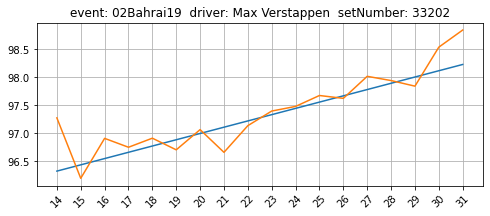

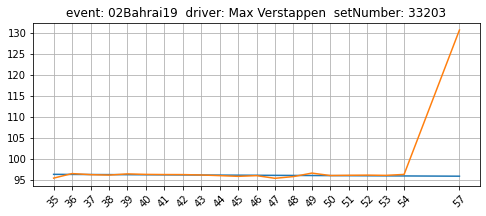

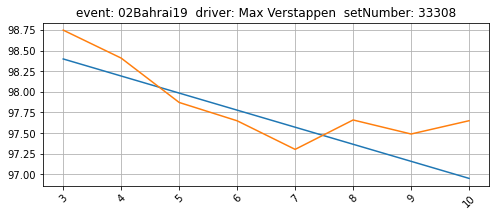

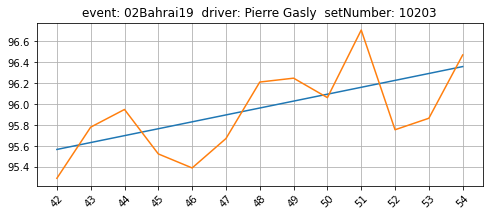

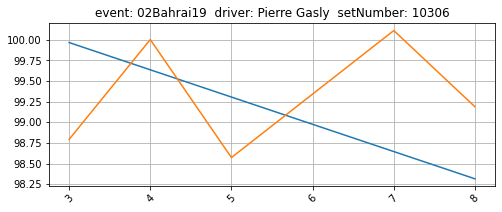

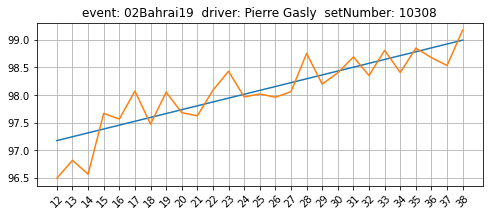

In [296]:
### plot some of deg lines 
def func_plot_deg(d_f):
    '''
    func method fits a line to the stints' lapTime data and 
    returns line slope and bias.
    '''    
    # Preparing X and y data from the given data
    x = d_f['runLapNumber'][(d_f['large_delta_time'])&(d_f['greater_than_5_laps'])].values
    y = d_f['lapTime'][(d_f['large_delta_time']) & (d_f['greater_than_5_laps']) ].values
    
    if len(x)<6: 
        return 
    
    # Calculating the parameters using the least square method
    deg_slope = d_f['deg_slope'][0]
    deg_bias = d_f['deg_bias'][0]
    
    y_line = deg_bias + deg_slope * x
    fig = plt.figure(figsize=(8,3))
#     plt.plot(d_f['runLapNumber'],d_f['lapTime'])
#     plt.plot(d_f[d_f['large_delta_time']]['runLapNumber'],
#              d_f[d_f['large_delta_time']]['lapTime'],
#              '.',color='black')
    plt.plot(x,y_line)
    plt.plot(x,y)
    plt.title('event: '+ d_f['events'][0]+ 
             '  driver: '+ d_f['drivers_name'][0]+
             '  setNumber: '+ d_f['setNumber'][0])
    ticks =  d_f['lapNumber'][(d_f['large_delta_time'])&(d_f['greater_than_5_laps'])].values
    plt.xticks(x,ticks,rotation=45)
    plt.grid()
    plt.show
    return

events = np.unique(df['events'])
for evnt in [ '02Bahrai19']: #'01Austra19', '01Bahrai21',
    drivers = np.unique(df['drivers_name'][(df['events']==evnt) &  (df['sessions']=='Race')])
    for drvs in drivers:
        setNumbers =  np.unique(df['setNumber'][(df['events']==evnt) & (df['drivers_name']==drvs)  &  (df['sessions']=='Race')])
        for setNm in setNumbers:
            sub_df = df[(df['events']==evnt) & (df['drivers_name']==drvs) &  (df['sessions']=='Race') & (df['setNumber']==setNm)].reset_index(drop=True)
            if len(sub_df)>=6:
                func_plot_deg(sub_df)
#                 print(func(sub_df) )

<a id='bestQual'></a>
### Extract slope of tyre degradation lines for different stints
It is assumed that 

In [306]:
def plot_lap_times(df_sub, event,driver, session):   

    
    a = 0 #len(df_sub) - df_sub['lapNumber'][-1:].values[0]
    b = len(df_sub)
    In = df_sub['lapNumber'][sub_df['lapType']=='IN'].values
    Out= df_sub['lapNumber'][sub_df['lapType']=='OUT'].values
    Out_In = df_sub['lapNumber'][sub_df['lapType']=='OUT_IN'].values
    Start = df_sub['lapNumber'][sub_df['lapType']=='START'].values
    
    print(In, Out,Out_In)
    
    tyres_compond = df_sub['tyres_compond'][a:b]
    lapNumber = range(a,b)
    
    print('Session: ',session, '\n','driver_name', np.unique(df_sub['drivers_name']),'\n', 
          'tyres_compond: ', np.unique(tyres_compond[tyres_compond.notnull()]))

    lapTime = df_sub['lapTime']
    lapTime_hat = df_sub['deg_bias']+df_sub['deg_slope']* df_sub['runLapNumber']

    lapNumber = np.arange(a,b)
    plot_laptime = lapTime[a:b]
    
    fig = plt.figure(figsize=(15,3))
    plt.plot(df_sub['lapNumber'], lapTime_hat)
    plt.plot(lapNumber, plot_laptime)
    
    plt.plot(lapNumber[df_sub['large_delta_time']],  
             df_sub[df_sub['large_delta_time']]['lapTime'] ,'.',color='black')

    for ii in (In):
        plt.axvline(x = ii, color = 'r', label = 'IN',linestyle='--')
    for ii in (Out):
        plt.axvline(x = ii, color = 'b', label = 'OUT',linestyle='--')
    for ii in (Out_In):
        plt.axvline(x = ii, color = 'g', label = 'OUT_IN',linestyle='--') 
    for ii in (Start):
        plt.axvline(x = ii, color = 'k', label = 'START',linestyle='--')         
    
    top = 105
    bot = np.nanmin(plot_laptime)
    print('bot: ',bot)
    if (~np.isnan(bot) )&(session!='Qual') :
        plt.ylim(bot,top)
        d = (top-bot)/10

        for ii in range(a,b,5):
            plt.text(ii-1,top-4*d , df_sub['tyres_compond'][ii], fontsize = 10) #np.nanmax(plot_laptime)-5
            plt.text(ii-1,top-3*d,df_sub['tyres_condition'][ii], fontsize = 10)
            plt.text(ii-1,top-2*d,df_sub['setNumber'][ii], fontsize = 10)
            plt.text(ii-1,top-1*d,df_sub['tyres_type'][ii], fontsize = 10)

        plt.xticks(lapNumber, df_sub['lapNumber'],rotation=45)
        plt.xlabel('lapNumber', fontsize = 18)
        plt.title('event: '+event+',    '+'driver: '+driver, fontsize = 16)
        plt.ylabel(' time', fontsize = 18)

        plt.grid(visible=True)
        plt.show()
    return

In [324]:
events = np.unique(df['events'])

for evnt in ['01Austra18','01Austra19', '01Bahrai21', '02Bahrai19']:
    drivers = np.unique(df['drivers_name'][df['events']==evnt])
    for drvs in drivers:
        
        sub_df = df[(df['events']==evnt) & (df['drivers_name']==drvs) &  (df['sessions']=='Race') ].sort_values(by = ['lapNumber']).reset_index(drop=True)
        if len(sub_df):
            plot_lap_times(sub_df,evnt,drvs, 'Race')
        
#         if len(sub_df):
#             plot_lap_times_diff(sub_df,evnt,drvs,'Race')
            
#         if len(sub_df):    
#             plot_fuel_normalized(sub_df)
            
        print('*' * 150,"\n")

In [309]:
df2[df2['events']=='02Bahrai19']

,events,country,sessions,drivers_name,tyres_compond,setNumber,best_qual_time
57,02Bahrai19,Bahrai,Qual,Max Verstappen,C_3,33306,89.579
58,02Bahrai19,Bahrai,Qual,Max Verstappen,C_3,33307,89.143
59,02Bahrai19,Bahrai,Qual,Max Verstappen,C_3,33308,89.109
60,02Bahrai19,Bahrai,Qual,Max Verstappen,C_3,33309,88.752
61,02Bahrai19,Bahrai,Qual,Pierre Gasly,C_3,10304,90.255
62,02Bahrai19,Bahrai,Qual,Pierre Gasly,C_3,10305,89.900
63,02Bahrai19,Bahrai,Qual,Pierre Gasly,C_3,10306,89.526
64,02Bahrai19,Bahrai,Qual,Pierre Gasly,C_3,10307,89.577


In [308]:
sub_df

,events,sessions,year1,country,year2,drivers_name,tyres_type,tyres_compond,tyres_condition,setNumber,lapNumber,lapType,runLapNumber,lapTime,large_delta_time,delta_lapTime,stintLength,greater_than_5_laps,deg_slope,deg_bias
0,02Bahrai19,Race,02,Bahrai,19,Pierre Gasly,OPTION,C_3,USED,10306,1,START,1,106.014,False,NaN,9,True,-0.330000,100.956667
1,02Bahrai19,Race,02,Bahrai,19,Pierre Gasly,OPTION,C_3,USED,10306,2,FULL,2,99.116,False,-6.898,9,True,-0.330000,100.956667
2,02Bahrai19,Race,02,Bahrai,19,Pierre Gasly,OPTION,C_3,USED,10306,3,FULL,3,98.794,True,-0.322,9,True,-0.330000,100.956667
3,02Bahrai19,Race,02,Bahrai,19,Pierre Gasly,OPTION,C_3,USED,10306,4,FULL,4,100.003,True,1.209,9,True,-0.330000,100.956667
4,02Bahrai19,Race,02,Bahrai,19,Pierre Gasly,OPTION,C_3,USED,10306,5,FULL,5,98.574,True,-1.429,9,True,-0.330000,100.956667
5,02Bahrai19,Race,02,Bahrai,19,Pierre Gasly,OPTION,C_3,USED,10306,6,FULL,6,99.343,True,0.769,9,True,-0.330000,100.956667
6,02Bahrai19,Race,02,Bahrai,19,Pierre Gasly,OPTION,C_3,USED,10306,7,FULL,7,100.112,True,0.769,9,True,-0.330000,100.956667
7,02Bahrai19,Race,02,Bahrai,19,Pierre Gasly,OPTION,C_3,USED,10306,8,FULL,8,99.189,True,-0.923,9,True,-0.330000,100.956667
8,02Bahrai19,Race,02,Bahrai,19,Pierre Gasly,OPTION,C_3,USED,10306,9,IN,9,102.197,False,3.008,9,True,-0.330000,100.956667
9,02Bahrai19,Race,02,Bahrai,19,Pierre Gasly,OPTION,C_3,NEW,10308,10,OUT,1,119.647,False,17.450,30,True,0.069891,96.965351
